In [1]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

# DATA EXPLORATION

In [2]:
DATASET = r'D:/SONY/EUROSAT/EuroSAT/2750'

LABELS = os.listdir(DATASET)
print(LABELS)

['Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'Residential', 'River']


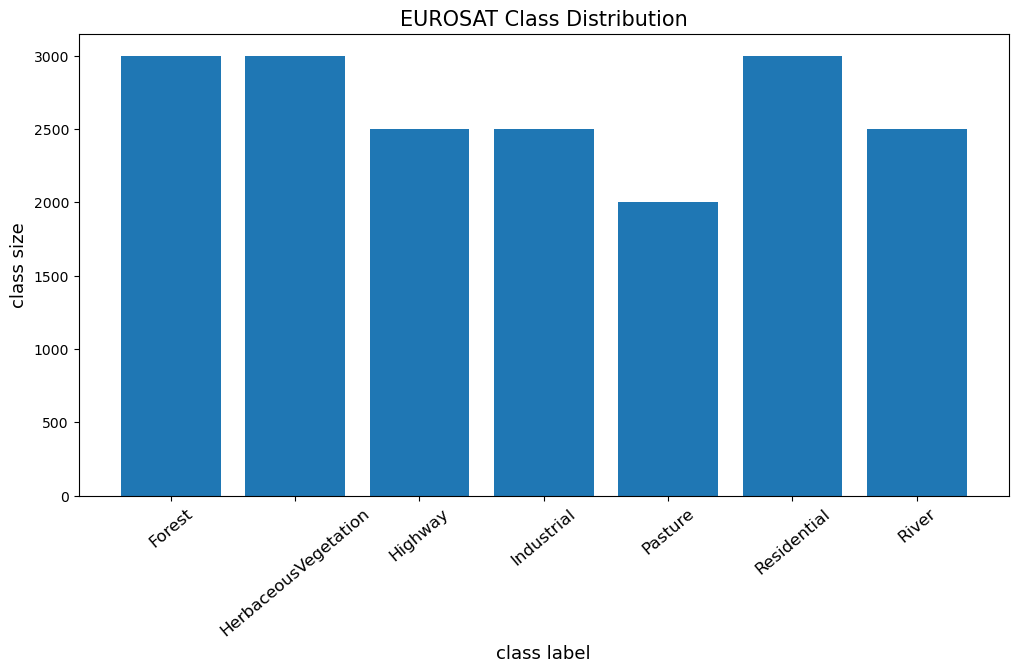

In [3]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [5]:
import matplotlib.pyplot as plt
import PIL.Image
import os
import numpy as np

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    num_images = len(paths)
    num_rows = 4
    num_cols = 5

    for i in range(min(num_images, num_rows * num_cols)):
        plt.subplot(num_rows, num_cols, i + 1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)


NameError: name 'img_paths' is not defined

# PREPROCESSING

In [6]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'D:/SONY/EUROSAT/TRAIN'
TEST_DIR = 'D:/SONY/EUROSAT/TEST'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [7]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]


In [8]:
# define a new path for each image depending on training or testing
new_train_paths = [re.sub('D:/SONY/EUROSAT/EuroSAT/2750','D:/SONY/EUROSAT/TRAIN' , i) for i in train_paths]
new_test_paths = [re.sub('D:/SONY/EUROSAT/EuroSAT/2750', 'D:/SONY/EUROSAT/TEST', i) for i in test_paths]

train_path_map = list((zip(train_paths, new_train_paths)))
test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
print("moving training files..")
for i in tqdm(train_path_map):
    if not os.path.exists(i[1]):
        if not os.path.exists(re.sub('training', 'testing', i[1])):
            shutil.copy(i[0], i[1])
    
print("moving testing files..")
for i in tqdm(test_path_map):
    if not os.path.exists(i[1]):
        if not os.path.exists(re.sub('training', 'testing', i[1])):
            shutil.copy(i[0], i[1])

moving training files..


100%|█████████████████████████████████████████████████████████████████████████| 14800/14800 [00:01<00:00, 10115.91it/s]


moving testing files..


100%|████████████████████████████████████████████████████████████████████████████| 3700/3700 [00:00<00:00, 9953.23it/s]


In [9]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)


Found 14800 images belonging to 7 classes.
Found 3700 images belonging to 7 classes.


In [10]:
print(train_generator.class_indices)

{'Forest': 0, 'HerbaceousVegetation': 1, 'Highway': 2, 'Industrial': 3, 'Pasture': 4, 'Residential': 5, 'River': 6}


In [11]:
np.save('class_indices', train_generator.class_indices)

# MACHINE LEARNING MODELS FOR LAND COVER CLASSIFICATION

In [12]:
# Using image data generator api in keras for making image dataset 
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    # by using batch_size as training data size we can extract data from this iterator
    batch_size=21600, 
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 14800 images belonging to 7 classes.
Found 3700 images belonging to 7 classes.


In [13]:
train = rf_train_generator.next()
X_train = train[0].reshape(14800, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(3700, 12288)
y_test = test[1]

# RANDOM FOREST MODEL 

In [14]:
from __future__ import division
from collections import Counter
import random
import numpy as np
from scipy.stats import mode


def shuffle_in_unison(a, b):
    """ Shuffles two lists of equal length and keeps corresponding elements in the same index. """
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


def entropy(Y):
    """ In information theory, entropy is a measure of the uncertanty of a random sample from a group. """
    
    distribution = Counter(Y)
    s = 0.0
    total = len(Y)
    for y, num_y in distribution.items():
        probability_y = (num_y/total)
        s += (probability_y)*np.log(probability_y)
    return -s


def information_gain(y, y_true, y_false):
    """ The reduction in entropy from splitting data into two groups. """
    return entropy(y) - (entropy(y_true)*len(y_true) + entropy(y_false)*len(y_false))/len(y)

In [15]:
# Implementing a Decision Tree Classifier

class DecisionTreeClassifier(object):
    """ A decision tree classifier.
    A decision tree is a structure in which each node represents a binary
    conditional decision on a specific feature, each branch represents the
    outcome of the decision, and each leaf node represents a final
    classification.
    """

    def __init__(self, max_features=lambda x: x, max_depth=10,
                    min_samples_split=2):
        """
        Args:
            max_features: A function that controls the number of features to
                randomly consider at each split. The argument will be the number
                of features in the data.
            max_depth: The maximum number of levels the tree can grow downwards
                before forcefully becoming a leaf.
            min_samples_split: The minimum number of samples needed at a node to
                justify a new node split.
        """

        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split


    def fit(self, X, y):
        """ Builds the tree by chooseing decision rules for each node based on
        the data. """

        n_features = X.shape[1]
        n_sub_features = int(self.max_features(n_features))
        feature_indices = random.sample(range(n_features), n_sub_features)
        
        self.trunk = self.build_tree(X, y, feature_indices, 0)


    def predict(self, X):
        """ Predict the class of each sample in X. """

        num_samples = X.shape[0]
        y = np.empty(num_samples)
        for j in range(num_samples):
            node = self.trunk

            while isinstance(node, Node):
                if X[j][node.feature_index] <= node.threshold:
                    node = node.branch_true
                else:
                    node = node.branch_false
            y[j] = node

        return y


    def build_tree(self, X, y, feature_indices, depth):
        """ Recursivly builds a decision tree. """

        if depth is self.max_depth or len(y) < self.min_samples_split or entropy(y) is 0:
            return mode(y)[0][0]
        
        feature_index, threshold = find_split(X, y, feature_indices)

        X_true, y_true, X_false, y_false = split(X, y, feature_index, threshold)
        if y_true.shape[0] is 0 or y_false.shape[0] is 0:
            return mode(y)[0][0]
        
        branch_true = self.build_tree(X_true, y_true, feature_indices, depth + 1)
        branch_false = self.build_tree(X_false, y_false, feature_indices, depth + 1)

        return Node(feature_index, threshold, branch_true, branch_false)


def find_split(X, y, feature_indices):
    """ Returns the best split rule for a tree node. """

    num_features = X.shape[1]

    best_gain = 0
    best_feature_index = 0
    best_threshold = 0
    for feature_index in feature_indices:
        values = sorted(set(X[:, feature_index])) ### better way

        for j in range(len(values) - 1):
            threshold = (values[j] + values[j+1])/2
            X_true, y_true, X_false, y_false = split(X, y, feature_index, threshold)
            gain = information_gain(y, y_true, y_false)

            if gain > best_gain:
                best_gain = gain
                best_feature_index = feature_index
                best_threshold = threshold

    return best_feature_index, best_threshold


class Node(object):
    """ A node in a decision tree with the binary condition xi <= t. """

    def __init__(self, feature_index, threshold, branch_true, branch_false):
        self.feature_index = feature_index
        self.threshold = threshold
        self.branch_true = branch_true
        self.branch_false = branch_false


def split(X, y, feature_index, threshold):
    """ Splits X and y based on the binary condition xi <= threshold. """

    X_true = []
    y_true = []
    X_false = []
    y_false = []

    for j in range(len(y)):
        if X[j][feature_index] <= threshold:
            X_true.append(X[j])
            y_true.append(y[j])
        else:
            X_false.append(X[j])
            y_false.append(y[j])

    X_true = np.array(X_true)
    y_true = np.array(y_true)
    X_false = np.array(X_false)
    y_false = np.array(y_false)

    return X_true, y_true, X_false, y_false

<>:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:67: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:67: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:67: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:67: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\sonymol.vk\AppData\Local\Temp\ipykernel_8544\3435122635.py:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if depth is self.max_depth or len(y) < self.min_samples_split or entropy(y) is 0:
C:\Users\sonymol.vk\AppData\Local\Temp\ipykernel_8544\3435122635.py:67: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if y_true.shape[0] is 0 or y_false.shape[0] is 0:
C:\Users\sonymol.vk\AppData\Local\Temp\ipykernel_8544\3435122635.py:67: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if y_true.shape[0] is 0 or y_false.shape[0] is 0:


In [16]:
# Implementing Random Forest Clasifier

class RandomForestClassifier(object):
    """ A random forest classifier.
    A random forest is a collection of decision trees that vote on a
    classification decision. Each tree is trained with a subset of the data and
    features.
    """

    def __init__(self, n_estimators=32, max_features=np.sqrt, max_depth=10,
        min_samples_split=2, bootstrap=0.9):
        """
        Args:
            n_estimators: The number of decision trees in the forest.
            max_features: Controls the number of features to randomly consider
                at each split.
            max_depth: The maximum number of levels that the tree can grow
                downwards before forcefully becoming a leaf.
            min_samples_split: The minimum number of samples needed at a node to
                justify a new node split.
            bootstrap: The fraction of randomly choosen data to fit each tree on.
        """
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.bootstrap = bootstrap
        self.forest = []


    def fit(self, X, y):
        """ Creates a forest of decision trees using a random subset of data and
            features. """
        self.forest = []
        n_samples = len(y)
        n_sub_samples = round(n_samples*self.bootstrap)
        
        for i in range(self.n_estimators):
            shuffle_in_unison(X, y)
            X_subset = X[:n_sub_samples]
            y_subset = y[:n_sub_samples]

            tree = DecisionTreeClassifier(self.max_features, self.max_depth,
                                            self.min_samples_split)
            tree.fit(X_subset, y_subset)
            self.forest.append(tree)


    def predict(self, X):
        """ Predict the class of each sample in X. """
        n_samples = X.shape[0]
        n_trees = len(self.forest)
        predictions = np.empty([n_trees, n_samples])
        for i in range(n_trees):
            predictions[i] = self.forest[i].predict(X)

        return mode(predictions)[0][0]


    def score(self, X, y):
        """ Return the accuracy of the prediction of X compared to y. """
        y_predict = self.predict(X)
        n_samples = len(y)
        correct = 0
        for i in range(n_samples):
            if y_predict[i] == y[i]:
                correct = correct + 1
        accuracy = correct/n_samples
        return accuracyG

In [17]:
# Creating mini batches of training data as training on whole data is difficult
ids_2 = np.random.choice(len(X_train), size=2160, replace=False)
X_train_mini_2 = X_train[ids_2]
y_train_mini_2 = rf_train_generator.classes[ids_2]

In [18]:
forest = RandomForestClassifier(n_estimators=2)
forest.fit(X_train_mini_2, y_train_mini_2)

C:\Users\sonymol.vk\AppData\Local\Temp\ipykernel_8544\3435122635.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return mode(y)[0][0]
C:\Users\sonymol.vk\AppData\Local\Temp\ipykernel_8544\3435122635.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return 

In [19]:
accuracy = forest.score(X_test, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(accuracy))

C:\Users\sonymol.vk\AppData\Local\Temp\ipykernel_8544\2459092160.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return mode(predictions)[0][0]


NameError: name 'accuracyG' is not defined

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have already trained your RandomForestClassifier and have the trained model in the variable 'forest'

# Predict the labels for your test data
y_pred = forest.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(rf_test_generator.classes, y_pred)

# Print the accuracy score
print("Accuracy Score: {:.4f}".format(accuracy))


C:\Users\sonymol.vk\AppData\Local\Temp\ipykernel_8544\2459092160.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return mode(predictions)[0][0]


Accuracy Score: 0.4435
